# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

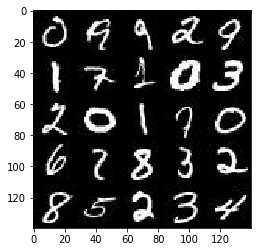

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

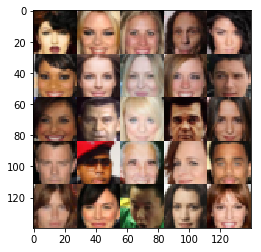

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_images = tf.placeholder(dtype = tf.float32, shape = (None, image_width, image_height, image_channels),
                                 name = 'real_images')
    #print (image_width, image_height, image_channels)
    
    z_input = tf.placeholder(dtype = tf.float32, shape = (None, z_dim), name = 'z_input')
    learing_rate = tf.placeholder(dtype = tf.float32, shape = None, name = 'lr')

    return real_images, z_input, learing_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse = reuse):
        # With a wave of my wand, I generate . . . MAGIC NUMBERS! WHAM-BAM-ALAKAZAM
        d1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same', 
                             kernel_initializer = tf.contrib.layers.xavier_initializer(uniform = False))
        relu1 = tf.maximum(alpha * d1, d1)
        #print(relu1.get_shape().as_list())
        
        d2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = 'same', 
                             kernel_initializer = tf.contrib.layers.xavier_initializer(uniform = False))
        bn2 = tf.layers.batch_normalization(d2, training = True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print(relu2.get_shape().as_list())
        
        d3 = tf.layers.conv2d(relu2, 256, 5, strides = 2, padding = 'same', 
                             kernel_initializer = tf.contrib.layers.xavier_initializer(uniform = False))
        bn3 = tf.layers.batch_normalization(d3, training = True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #print(relu3.get_shape().as_list())
        
        d4 = tf.layers.conv2d(relu3, 512, 5, strides = 2, padding = 'same', 
                             kernel_initializer = tf.contrib.layers.xavier_initializer(uniform = False))
        bn4 = tf.layers.batch_normalization(d4, training = True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        #print(relu4.get_shape().as_list())
        
        
        flat = tf.reshape(relu4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1, 
                                kernel_initializer = tf.contrib.layers.xavier_initializer(uniform = False))
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2 
    
    # Alright Mr. Forums-guy, I'll try that, but it can't possibly be righ- oh fark me.
    with tf.variable_scope('generator', reuse = not is_train) as scope:
        # WHA-FLA-ABRACADABRA
        l1 = tf.layers.dense(z, 7*7*768)
        
        l1 = tf.reshape(l1, (-1, 7, 7, 768))
        l1 = tf.layers.batch_normalization(l1, training = is_train)
        l1 = tf.maximum(alpha * l1, l1)
        #print(l1.get_shape().as_list())
        
        l2 = tf.layers.conv2d_transpose(l1, 512, 5, strides = 2, padding = 'same', 
                                       kernel_initializer = tf.contrib.layers.xavier_initializer(uniform = False))
        l2 = tf.layers.batch_normalization(l2, training = is_train)
        l2 = tf.maximum(alpha * l2, l2)
        #print(l2.get_shape().as_list())
        
        l3 = tf.layers.conv2d_transpose(l2, 256, 5, strides = 2, padding = 'same', 
                                       kernel_initializer = tf.contrib.layers.xavier_initializer(uniform = False))
        l3 = tf.layers.batch_normalization(l3, training = is_train)
        l3 = tf.maximum(alpha * l3, l3)
        #print(l3.get_shape().as_list())
        
        l4 = tf.layers.conv2d_transpose(l3, 128, 5, strides = 1, padding = 'same', 
                                       kernel_initializer = tf.contrib.layers.xavier_initializer(uniform = False))
        l4 = tf.layers.batch_normalization(l4, training = is_train)
        l4 = tf.maximum(alpha * l4, l4)
        #print(l4.get_shape().as_list())
        
        logits = tf.layers.conv2d_transpose(l4, out_channel_dim, 5, strides = 1, padding = 'same', 
                                           kernel_initializer = tf.contrib.layers.xavier_initializer(uniform = False))
        #print(logits.get_shape().as_list())
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.9
    
    gen = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen, reuse = True)
    
    dis_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_logits_real, labels = tf.ones_like(dis_model_real) * smooth))
    dis_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_logits_fake, labels = tf.zeros_like(dis_model_fake)))
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_logits_fake, labels = tf.ones_like(dis_model_fake)))
    
    dis_loss = dis_loss_fake + dis_loss_real
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
         print_every = 10, show_every = 100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """    

    # Book keeping
    _, image_width, image_height, image_channels = data_shape
    steps = 0
    losses = []
    
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images * 2
                
                noize = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                sess.run(d_opt, feed_dict = {input_real: batch_images, input_z: noize})
                sess.run(g_opt, feed_dict = {input_z: noize, input_real: batch_images})
                
                if steps % print_every == 0:
                    train_loss_d = sess.run(d_loss, feed_dict = {input_real: batch_images, input_z: noize})
                    train_loss_g = g_loss.eval({input_z: noize})
                    
                    print('Epoch {}/{}...'.format(epoch_i + 1, epochs),
                            'Discriminator Loss: {:.4f}...'.format(train_loss_d),
                            'Generator Loss: {:.4f}'.format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    # gen_samples = sess.run(
                    #               generator(input_z, image_channels, reuse = True, training = False),
                    #               feed_dict = {input_z: sample_z})
                    # samples.append(gen_samples)
                                 
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    
            # show final each epoch
            show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4556... Generator Loss: 2.6957
Epoch 1/2... Discriminator Loss: 0.7554... Generator Loss: 1.9800
Epoch 1/2... Discriminator Loss: 0.7850... Generator Loss: 2.3464
Epoch 1/2... Discriminator Loss: 2.0158... Generator Loss: 0.2372
Epoch 1/2... Discriminator Loss: 1.4552... Generator Loss: 0.7157
Epoch 1/2... Discriminator Loss: 1.3813... Generator Loss: 0.9785
Epoch 1/2... Discriminator Loss: 1.4342... Generator Loss: 1.4150
Epoch 1/2... Discriminator Loss: 1.4893... Generator Loss: 0.4992
Epoch 1/2... Discriminator Loss: 1.3163... Generator Loss: 0.6753
Epoch 1/2... Discriminator Loss: 1.2676... Generator Loss: 0.8281


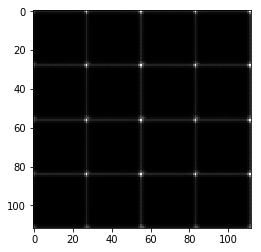

Epoch 1/2... Discriminator Loss: 1.5498... Generator Loss: 1.7101
Epoch 1/2... Discriminator Loss: 1.4938... Generator Loss: 1.5590
Epoch 1/2... Discriminator Loss: 1.3510... Generator Loss: 1.5230
Epoch 1/2... Discriminator Loss: 1.1238... Generator Loss: 1.2244
Epoch 1/2... Discriminator Loss: 1.9157... Generator Loss: 0.2667
Epoch 1/2... Discriminator Loss: 1.0646... Generator Loss: 1.0884
Epoch 1/2... Discriminator Loss: 1.1405... Generator Loss: 0.7815
Epoch 1/2... Discriminator Loss: 1.3237... Generator Loss: 0.8701
Epoch 1/2... Discriminator Loss: 1.2774... Generator Loss: 0.5873
Epoch 1/2... Discriminator Loss: 1.1234... Generator Loss: 0.8678


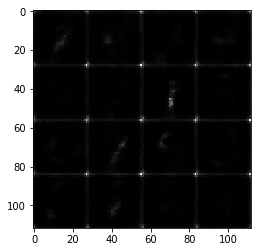

Epoch 1/2... Discriminator Loss: 1.2517... Generator Loss: 0.8236
Epoch 1/2... Discriminator Loss: 1.3585... Generator Loss: 1.2649
Epoch 1/2... Discriminator Loss: 1.7090... Generator Loss: 2.2536
Epoch 1/2... Discriminator Loss: 1.1919... Generator Loss: 0.9448
Epoch 1/2... Discriminator Loss: 1.3005... Generator Loss: 1.2738
Epoch 1/2... Discriminator Loss: 1.1549... Generator Loss: 0.9602
Epoch 1/2... Discriminator Loss: 1.1764... Generator Loss: 1.3074
Epoch 1/2... Discriminator Loss: 1.1002... Generator Loss: 1.2002
Epoch 1/2... Discriminator Loss: 1.2818... Generator Loss: 1.1861
Epoch 1/2... Discriminator Loss: 1.1190... Generator Loss: 1.2175


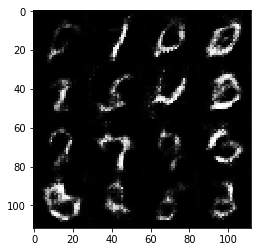

Epoch 1/2... Discriminator Loss: 1.1804... Generator Loss: 0.7961
Epoch 1/2... Discriminator Loss: 1.3010... Generator Loss: 0.7759
Epoch 1/2... Discriminator Loss: 1.3155... Generator Loss: 1.2887
Epoch 1/2... Discriminator Loss: 1.1422... Generator Loss: 1.0818
Epoch 1/2... Discriminator Loss: 1.1328... Generator Loss: 0.8405
Epoch 1/2... Discriminator Loss: 1.5678... Generator Loss: 0.4492
Epoch 1/2... Discriminator Loss: 1.2951... Generator Loss: 0.7635
Epoch 1/2... Discriminator Loss: 1.3270... Generator Loss: 0.6159
Epoch 1/2... Discriminator Loss: 1.5719... Generator Loss: 0.4048
Epoch 1/2... Discriminator Loss: 1.1368... Generator Loss: 0.9248


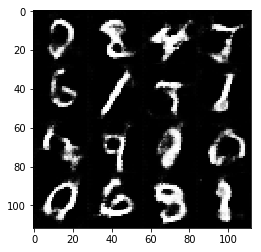

Epoch 1/2... Discriminator Loss: 1.4909... Generator Loss: 1.9763
Epoch 1/2... Discriminator Loss: 1.3083... Generator Loss: 0.6376
Epoch 1/2... Discriminator Loss: 1.4478... Generator Loss: 0.4543
Epoch 1/2... Discriminator Loss: 1.2147... Generator Loss: 0.7266
Epoch 1/2... Discriminator Loss: 1.3138... Generator Loss: 0.5625
Epoch 1/2... Discriminator Loss: 1.4980... Generator Loss: 0.4183


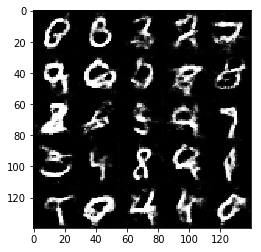

Epoch 2/2... Discriminator Loss: 1.5207... Generator Loss: 0.4192
Epoch 2/2... Discriminator Loss: 1.1321... Generator Loss: 1.0602
Epoch 2/2... Discriminator Loss: 1.3707... Generator Loss: 0.4954
Epoch 2/2... Discriminator Loss: 1.1784... Generator Loss: 0.7274


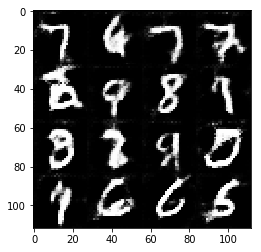

Epoch 2/2... Discriminator Loss: 1.7050... Generator Loss: 0.3216
Epoch 2/2... Discriminator Loss: 1.2522... Generator Loss: 0.7237
Epoch 2/2... Discriminator Loss: 1.5369... Generator Loss: 1.6190
Epoch 2/2... Discriminator Loss: 1.1159... Generator Loss: 0.8277
Epoch 2/2... Discriminator Loss: 1.2835... Generator Loss: 1.2510
Epoch 2/2... Discriminator Loss: 1.1957... Generator Loss: 1.3292
Epoch 2/2... Discriminator Loss: 1.2019... Generator Loss: 1.0274
Epoch 2/2... Discriminator Loss: 1.5390... Generator Loss: 0.4285
Epoch 2/2... Discriminator Loss: 1.4955... Generator Loss: 0.5353
Epoch 2/2... Discriminator Loss: 1.2551... Generator Loss: 0.6062


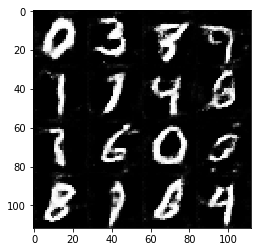

Epoch 2/2... Discriminator Loss: 1.1808... Generator Loss: 1.1158
Epoch 2/2... Discriminator Loss: 1.6759... Generator Loss: 1.7236
Epoch 2/2... Discriminator Loss: 1.2059... Generator Loss: 0.8942
Epoch 2/2... Discriminator Loss: 1.2051... Generator Loss: 0.7681
Epoch 2/2... Discriminator Loss: 2.2316... Generator Loss: 0.1840
Epoch 2/2... Discriminator Loss: 1.2226... Generator Loss: 0.6783
Epoch 2/2... Discriminator Loss: 1.3683... Generator Loss: 0.8015
Epoch 2/2... Discriminator Loss: 1.2694... Generator Loss: 0.9550
Epoch 2/2... Discriminator Loss: 1.3531... Generator Loss: 1.5311
Epoch 2/2... Discriminator Loss: 1.1604... Generator Loss: 0.8047


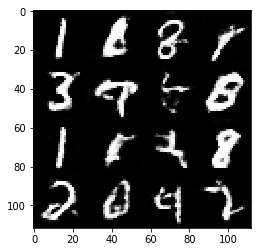

Epoch 2/2... Discriminator Loss: 1.2955... Generator Loss: 1.3985
Epoch 2/2... Discriminator Loss: 1.2237... Generator Loss: 0.8218
Epoch 2/2... Discriminator Loss: 1.2212... Generator Loss: 0.6318
Epoch 2/2... Discriminator Loss: 1.3007... Generator Loss: 1.5286
Epoch 2/2... Discriminator Loss: 1.2450... Generator Loss: 0.7551
Epoch 2/2... Discriminator Loss: 1.2177... Generator Loss: 0.8348
Epoch 2/2... Discriminator Loss: 2.0246... Generator Loss: 0.2378
Epoch 2/2... Discriminator Loss: 1.2787... Generator Loss: 0.7289
Epoch 2/2... Discriminator Loss: 0.9549... Generator Loss: 1.4001
Epoch 2/2... Discriminator Loss: 0.9989... Generator Loss: 1.3130


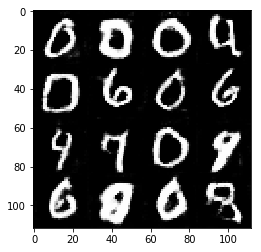

Epoch 2/2... Discriminator Loss: 1.5554... Generator Loss: 1.3656
Epoch 2/2... Discriminator Loss: 1.2724... Generator Loss: 0.6501
Epoch 2/2... Discriminator Loss: 1.1323... Generator Loss: 0.7358
Epoch 2/2... Discriminator Loss: 1.1707... Generator Loss: 1.2231
Epoch 2/2... Discriminator Loss: 1.0936... Generator Loss: 0.9309
Epoch 2/2... Discriminator Loss: 1.4334... Generator Loss: 0.4782
Epoch 2/2... Discriminator Loss: 1.1124... Generator Loss: 1.0066
Epoch 2/2... Discriminator Loss: 1.3679... Generator Loss: 0.5167
Epoch 2/2... Discriminator Loss: 1.1564... Generator Loss: 0.6932
Epoch 2/2... Discriminator Loss: 1.6506... Generator Loss: 0.3685


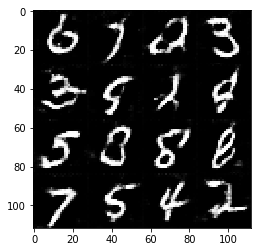

Epoch 2/2... Discriminator Loss: 1.1748... Generator Loss: 0.7378
Epoch 2/2... Discriminator Loss: 1.3143... Generator Loss: 0.7745
Epoch 2/2... Discriminator Loss: 1.0618... Generator Loss: 0.8881


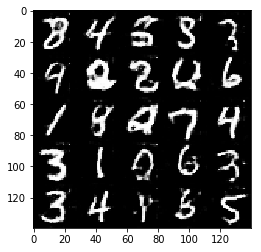

In [12]:
batch_size = 128
z_dim = 100 # was 64
learning_rate = 0.0002
beta1 = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

## CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7789... Generator Loss: 1.3113
Epoch 1/1... Discriminator Loss: 3.5576... Generator Loss: 0.0995
Epoch 1/1... Discriminator Loss: 2.6794... Generator Loss: 0.1473
Epoch 1/1... Discriminator Loss: 2.2233... Generator Loss: 0.1823
Epoch 1/1... Discriminator Loss: 1.5761... Generator Loss: 3.0818
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 2.2019
Epoch 1/1... Discriminator Loss: 0.9156... Generator Loss: 2.0204
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 2.7483
Epoch 1/1... Discriminator Loss: 0.8036... Generator Loss: 1.2978
Epoch 1/1... Discriminator Loss: 0.8036... Generator Loss: 1.0678


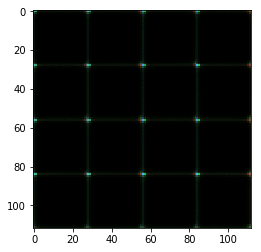

Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 2.5009
Epoch 1/1... Discriminator Loss: 0.8326... Generator Loss: 2.2884
Epoch 1/1... Discriminator Loss: 0.8652... Generator Loss: 1.1023
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.7496... Generator Loss: 0.3159
Epoch 1/1... Discriminator Loss: 2.1804... Generator Loss: 0.1894
Epoch 1/1... Discriminator Loss: 0.6328... Generator Loss: 1.8915
Epoch 1/1... Discriminator Loss: 1.7324... Generator Loss: 0.3222
Epoch 1/1... Discriminator Loss: 0.8458... Generator Loss: 1.2665
Epoch 1/1... Discriminator Loss: 1.8149... Generator Loss: 0.2832


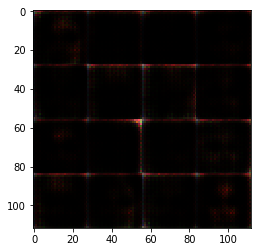

Epoch 1/1... Discriminator Loss: 1.5575... Generator Loss: 2.8138
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 1.6788
Epoch 1/1... Discriminator Loss: 1.8260... Generator Loss: 0.2795
Epoch 1/1... Discriminator Loss: 2.1272... Generator Loss: 0.1999
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.8632... Generator Loss: 2.2052
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 2.4071
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 1.4106
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.4475
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.5202


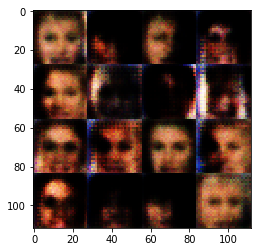

Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 2.6378
Epoch 1/1... Discriminator Loss: 0.6614... Generator Loss: 2.3748
Epoch 1/1... Discriminator Loss: 1.7025... Generator Loss: 0.3120
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 3.2753
Epoch 1/1... Discriminator Loss: 0.7513... Generator Loss: 1.9215
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 1.4852
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 0.7919... Generator Loss: 1.2776
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 1.9057


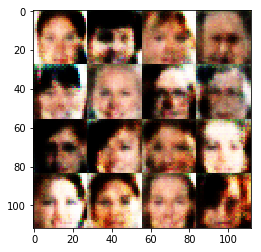

Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 2.1081
Epoch 1/1... Discriminator Loss: 0.8245... Generator Loss: 1.1891
Epoch 1/1... Discriminator Loss: 0.8278... Generator Loss: 1.1114
Epoch 1/1... Discriminator Loss: 1.9550... Generator Loss: 0.2371
Epoch 1/1... Discriminator Loss: 0.7466... Generator Loss: 2.2646
Epoch 1/1... Discriminator Loss: 0.7740... Generator Loss: 2.9212
Epoch 1/1... Discriminator Loss: 0.4336... Generator Loss: 3.8355
Epoch 1/1... Discriminator Loss: 2.7748... Generator Loss: 3.3179
Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 3.9620
Epoch 1/1... Discriminator Loss: 0.6859... Generator Loss: 2.7835


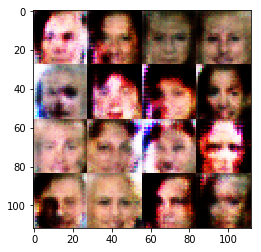

Epoch 1/1... Discriminator Loss: 2.0718... Generator Loss: 1.6083
Epoch 1/1... Discriminator Loss: 0.9478... Generator Loss: 0.9360
Epoch 1/1... Discriminator Loss: 0.6432... Generator Loss: 2.0837
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 1.1437
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 1.9485
Epoch 1/1... Discriminator Loss: 0.6908... Generator Loss: 1.5277
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.7722... Generator Loss: 0.2859
Epoch 1/1... Discriminator Loss: 0.6576... Generator Loss: 1.5371


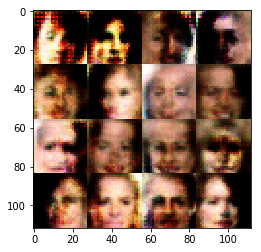

Epoch 1/1... Discriminator Loss: 0.7032... Generator Loss: 3.5833
Epoch 1/1... Discriminator Loss: 0.6833... Generator Loss: 1.4621
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 3.7843
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 2.8220
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 0.8305... Generator Loss: 1.1302
Epoch 1/1... Discriminator Loss: 0.6853... Generator Loss: 1.4985
Epoch 1/1... Discriminator Loss: 3.2184... Generator Loss: 3.4378
Epoch 1/1... Discriminator Loss: 0.4959... Generator Loss: 2.5645
Epoch 1/1... Discriminator Loss: 0.5566... Generator Loss: 2.9595


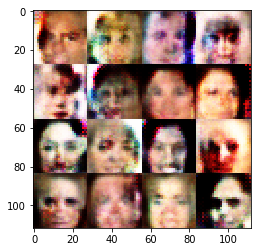

Epoch 1/1... Discriminator Loss: 0.5336... Generator Loss: 2.2246
Epoch 1/1... Discriminator Loss: 0.9453... Generator Loss: 1.5933
Epoch 1/1... Discriminator Loss: 1.7476... Generator Loss: 2.5635
Epoch 1/1... Discriminator Loss: 0.5026... Generator Loss: 2.7999
Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 1.0752
Epoch 1/1... Discriminator Loss: 0.8040... Generator Loss: 2.8701
Epoch 1/1... Discriminator Loss: 0.6662... Generator Loss: 1.5392
Epoch 1/1... Discriminator Loss: 0.5112... Generator Loss: 2.3555
Epoch 1/1... Discriminator Loss: 1.1249... Generator Loss: 0.6942


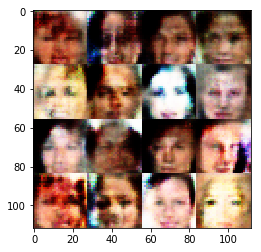

Epoch 1/1... Discriminator Loss: 0.6956... Generator Loss: 2.4638
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 1.7865
Epoch 1/1... Discriminator Loss: 0.7029... Generator Loss: 2.7983
Epoch 1/1... Discriminator Loss: 0.7221... Generator Loss: 2.6026
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 1.4510
Epoch 1/1... Discriminator Loss: 0.7664... Generator Loss: 3.0197
Epoch 1/1... Discriminator Loss: 0.6815... Generator Loss: 2.9465
Epoch 1/1... Discriminator Loss: 0.5782... Generator Loss: 2.5110
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 2.7587
Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 0.8674


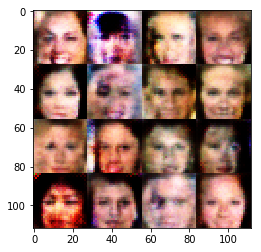

Epoch 1/1... Discriminator Loss: 0.5136... Generator Loss: 2.1684
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 0.5221... Generator Loss: 2.7996
Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 1.7174
Epoch 1/1... Discriminator Loss: 0.7616... Generator Loss: 1.1554
Epoch 1/1... Discriminator Loss: 0.8948... Generator Loss: 1.1932
Epoch 1/1... Discriminator Loss: 0.8735... Generator Loss: 1.0826
Epoch 1/1... Discriminator Loss: 0.6062... Generator Loss: 1.8482
Epoch 1/1... Discriminator Loss: 2.1354... Generator Loss: 0.2028
Epoch 1/1... Discriminator Loss: 0.6041... Generator Loss: 2.9218


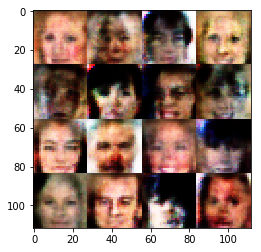

Epoch 1/1... Discriminator Loss: 0.8874... Generator Loss: 1.5505
Epoch 1/1... Discriminator Loss: 1.7024... Generator Loss: 2.5774
Epoch 1/1... Discriminator Loss: 0.7193... Generator Loss: 1.3844
Epoch 1/1... Discriminator Loss: 0.6273... Generator Loss: 1.5725
Epoch 1/1... Discriminator Loss: 0.8194... Generator Loss: 1.1753
Epoch 1/1... Discriminator Loss: 0.7044... Generator Loss: 3.6894
Epoch 1/1... Discriminator Loss: 0.5966... Generator Loss: 1.8156
Epoch 1/1... Discriminator Loss: 0.6525... Generator Loss: 1.5929
Epoch 1/1... Discriminator Loss: 0.4783... Generator Loss: 2.6321
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.7887


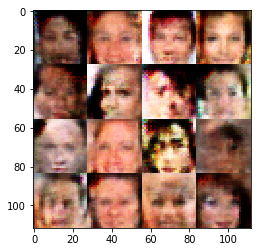

Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 1.8191
Epoch 1/1... Discriminator Loss: 0.5140... Generator Loss: 2.9330
Epoch 1/1... Discriminator Loss: 0.8676... Generator Loss: 2.8555
Epoch 1/1... Discriminator Loss: 0.7003... Generator Loss: 1.5242
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 0.6152... Generator Loss: 1.5576
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 0.6781... Generator Loss: 1.3644


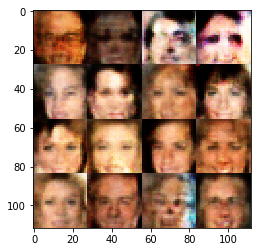

Epoch 1/1... Discriminator Loss: 0.6953... Generator Loss: 3.0874
Epoch 1/1... Discriminator Loss: 0.5311... Generator Loss: 1.9417
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 1.9185
Epoch 1/1... Discriminator Loss: 0.5614... Generator Loss: 1.7326
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 1.0233
Epoch 1/1... Discriminator Loss: 0.7692... Generator Loss: 1.1718
Epoch 1/1... Discriminator Loss: 0.7721... Generator Loss: 1.4458
Epoch 1/1... Discriminator Loss: 0.5632... Generator Loss: 1.7810
Epoch 1/1... Discriminator Loss: 1.7257... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.5875


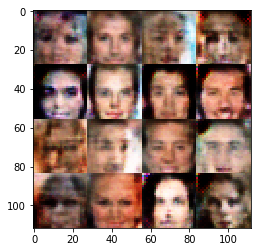

Epoch 1/1... Discriminator Loss: 0.6766... Generator Loss: 1.8806
Epoch 1/1... Discriminator Loss: 0.7238... Generator Loss: 1.2346
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.4924
Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 0.8175... Generator Loss: 3.3931
Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 0.8802
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.4873
Epoch 1/1... Discriminator Loss: 0.8445... Generator Loss: 0.9842
Epoch 1/1... Discriminator Loss: 0.4603... Generator Loss: 2.3271
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 2.2838


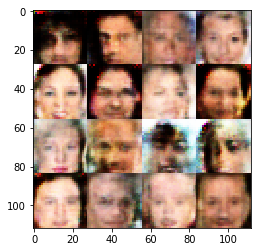

Epoch 1/1... Discriminator Loss: 0.5012... Generator Loss: 2.1650
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 0.5723... Generator Loss: 2.1839
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.4907
Epoch 1/1... Discriminator Loss: 0.5671... Generator Loss: 1.8219
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 1.9083
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 3.9876
Epoch 1/1... Discriminator Loss: 0.8184... Generator Loss: 1.0252
Epoch 1/1... Discriminator Loss: 0.6066... Generator Loss: 1.6298
Epoch 1/1... Discriminator Loss: 0.4030... Generator Loss: 2.9665


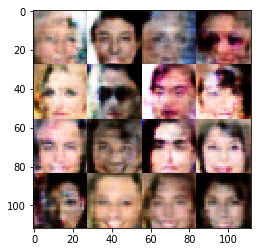

Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 4.2213
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 3.3315
Epoch 1/1... Discriminator Loss: 0.6634... Generator Loss: 2.7507
Epoch 1/1... Discriminator Loss: 0.7953... Generator Loss: 1.1038
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 2.5215
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.6256... Generator Loss: 2.9995
Epoch 1/1... Discriminator Loss: 0.4966... Generator Loss: 2.3840
Epoch 1/1... Discriminator Loss: 0.4909... Generator Loss: 2.6298
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.5289


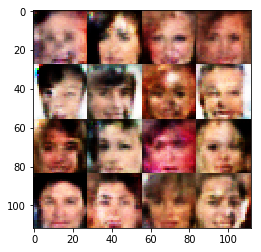

Epoch 1/1... Discriminator Loss: 0.6890... Generator Loss: 1.8042
Epoch 1/1... Discriminator Loss: 1.0147... Generator Loss: 1.4895
Epoch 1/1... Discriminator Loss: 0.5038... Generator Loss: 2.9035
Epoch 1/1... Discriminator Loss: 0.5143... Generator Loss: 2.4325
Epoch 1/1... Discriminator Loss: 0.8773... Generator Loss: 1.0327
Epoch 1/1... Discriminator Loss: 0.6172... Generator Loss: 1.5359
Epoch 1/1... Discriminator Loss: 0.4167... Generator Loss: 2.9524
Epoch 1/1... Discriminator Loss: 0.6288... Generator Loss: 2.2651
Epoch 1/1... Discriminator Loss: 2.2169... Generator Loss: 2.9997
Epoch 1/1... Discriminator Loss: 0.4236... Generator Loss: 2.8287


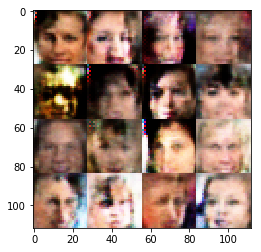

Epoch 1/1... Discriminator Loss: 0.7074... Generator Loss: 1.2732
Epoch 1/1... Discriminator Loss: 0.4500... Generator Loss: 2.5855
Epoch 1/1... Discriminator Loss: 0.6378... Generator Loss: 1.4402
Epoch 1/1... Discriminator Loss: 0.6501... Generator Loss: 2.1089
Epoch 1/1... Discriminator Loss: 0.5432... Generator Loss: 1.9191
Epoch 1/1... Discriminator Loss: 0.6171... Generator Loss: 2.8002
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 0.6960... Generator Loss: 1.7999
Epoch 1/1... Discriminator Loss: 1.7004... Generator Loss: 2.3415
Epoch 1/1... Discriminator Loss: 0.6418... Generator Loss: 2.2314


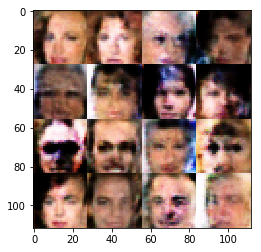

Epoch 1/1... Discriminator Loss: 1.8662... Generator Loss: 2.3698
Epoch 1/1... Discriminator Loss: 0.4816... Generator Loss: 2.8178
Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 2.6921
Epoch 1/1... Discriminator Loss: 0.6216... Generator Loss: 1.8291
Epoch 1/1... Discriminator Loss: 0.5006... Generator Loss: 2.1972
Epoch 1/1... Discriminator Loss: 1.9142... Generator Loss: 2.4185
Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 1.8384
Epoch 1/1... Discriminator Loss: 0.5705... Generator Loss: 2.9777
Epoch 1/1... Discriminator Loss: 1.5660... Generator Loss: 2.1765
Epoch 1/1... Discriminator Loss: 0.5516... Generator Loss: 2.5338


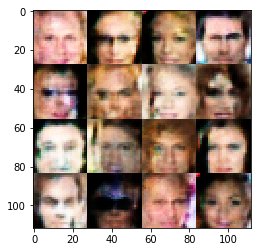

Epoch 1/1... Discriminator Loss: 0.5225... Generator Loss: 1.9305
Epoch 1/1... Discriminator Loss: 1.6942... Generator Loss: 0.3492
Epoch 1/1... Discriminator Loss: 1.7164... Generator Loss: 2.3839
Epoch 1/1... Discriminator Loss: 0.6055... Generator Loss: 1.8455
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 2.5109
Epoch 1/1... Discriminator Loss: 0.8654... Generator Loss: 1.3491
Epoch 1/1... Discriminator Loss: 0.5068... Generator Loss: 2.8946
Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 2.3409
Epoch 1/1... Discriminator Loss: 0.7817... Generator Loss: 1.1861
Epoch 1/1... Discriminator Loss: 0.8003... Generator Loss: 1.0844


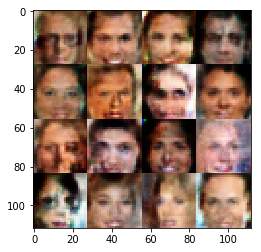

Epoch 1/1... Discriminator Loss: 0.4354... Generator Loss: 2.6469
Epoch 1/1... Discriminator Loss: 0.6072... Generator Loss: 1.5516
Epoch 1/1... Discriminator Loss: 0.6833... Generator Loss: 1.5290
Epoch 1/1... Discriminator Loss: 0.8021... Generator Loss: 2.8564
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 1.1865
Epoch 1/1... Discriminator Loss: 0.9462... Generator Loss: 1.0208
Epoch 1/1... Discriminator Loss: 0.8764... Generator Loss: 1.0512
Epoch 1/1... Discriminator Loss: 0.5881... Generator Loss: 1.9577
Epoch 1/1... Discriminator Loss: 0.9092... Generator Loss: 0.9490
Epoch 1/1... Discriminator Loss: 0.4747... Generator Loss: 2.3243


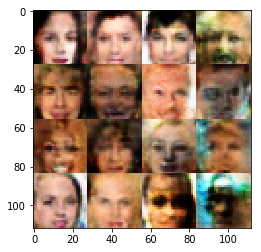

Epoch 1/1... Discriminator Loss: 0.5396... Generator Loss: 3.3044
Epoch 1/1... Discriminator Loss: 0.7833... Generator Loss: 1.1354
Epoch 1/1... Discriminator Loss: 0.5964... Generator Loss: 3.0101
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 1.9246
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 1.5652
Epoch 1/1... Discriminator Loss: 0.6376... Generator Loss: 2.5098
Epoch 1/1... Discriminator Loss: 0.5306... Generator Loss: 2.5753
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 1.9684
Epoch 1/1... Discriminator Loss: 0.7710... Generator Loss: 1.2918
Epoch 1/1... Discriminator Loss: 0.5969... Generator Loss: 1.7866


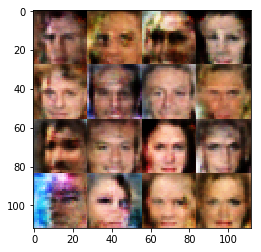

Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 2.7132
Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 1.6135
Epoch 1/1... Discriminator Loss: 0.3987... Generator Loss: 3.1207
Epoch 1/1... Discriminator Loss: 0.4675... Generator Loss: 2.3151
Epoch 1/1... Discriminator Loss: 0.8172... Generator Loss: 1.1875
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.4754
Epoch 1/1... Discriminator Loss: 0.7896... Generator Loss: 1.1824
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 0.4696... Generator Loss: 2.3058
Epoch 1/1... Discriminator Loss: 0.6477... Generator Loss: 1.6567


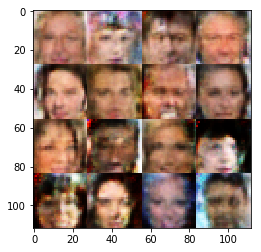

Epoch 1/1... Discriminator Loss: 0.4765... Generator Loss: 2.4124
Epoch 1/1... Discriminator Loss: 1.8816... Generator Loss: 0.2688
Epoch 1/1... Discriminator Loss: 0.6193... Generator Loss: 1.9253
Epoch 1/1... Discriminator Loss: 1.8109... Generator Loss: 3.5443
Epoch 1/1... Discriminator Loss: 0.6340... Generator Loss: 2.6940
Epoch 1/1... Discriminator Loss: 1.5675... Generator Loss: 3.0317
Epoch 1/1... Discriminator Loss: 0.8464... Generator Loss: 1.9564
Epoch 1/1... Discriminator Loss: 0.5525... Generator Loss: 2.1891
Epoch 1/1... Discriminator Loss: 0.6254... Generator Loss: 1.6216
Epoch 1/1... Discriminator Loss: 0.7513... Generator Loss: 3.5724


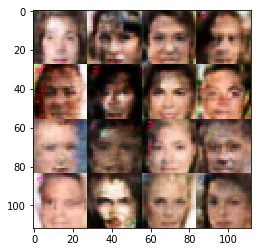

Epoch 1/1... Discriminator Loss: 0.4944... Generator Loss: 2.2919
Epoch 1/1... Discriminator Loss: 0.7313... Generator Loss: 2.7355
Epoch 1/1... Discriminator Loss: 0.6579... Generator Loss: 1.8414
Epoch 1/1... Discriminator Loss: 0.8326... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 0.5418... Generator Loss: 2.4073
Epoch 1/1... Discriminator Loss: 0.6660... Generator Loss: 1.3663
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 0.8129... Generator Loss: 2.5492
Epoch 1/1... Discriminator Loss: 0.6684... Generator Loss: 2.8814
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.5962


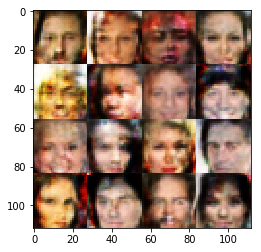

Epoch 1/1... Discriminator Loss: 0.5802... Generator Loss: 2.6428
Epoch 1/1... Discriminator Loss: 0.7436... Generator Loss: 1.2526
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.5675
Epoch 1/1... Discriminator Loss: 0.5635... Generator Loss: 1.8006
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 1.9987
Epoch 1/1... Discriminator Loss: 0.8217... Generator Loss: 2.0759
Epoch 1/1... Discriminator Loss: 0.5259... Generator Loss: 2.9604
Epoch 1/1... Discriminator Loss: 0.6899... Generator Loss: 2.0492
Epoch 1/1... Discriminator Loss: 0.7692... Generator Loss: 2.7826
Epoch 1/1... Discriminator Loss: 0.9317... Generator Loss: 1.1046


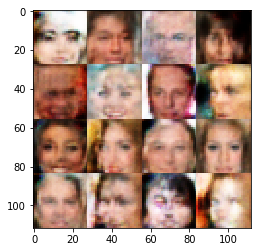

Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 2.9344
Epoch 1/1... Discriminator Loss: 0.5966... Generator Loss: 1.6641
Epoch 1/1... Discriminator Loss: 0.6066... Generator Loss: 1.6909
Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 0.5202... Generator Loss: 2.4944
Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 2.1564
Epoch 1/1... Discriminator Loss: 0.7843... Generator Loss: 2.5158
Epoch 1/1... Discriminator Loss: 0.6088... Generator Loss: 2.1360
Epoch 1/1... Discriminator Loss: 0.7172... Generator Loss: 3.1845
Epoch 1/1... Discriminator Loss: 0.6060... Generator Loss: 2.0649


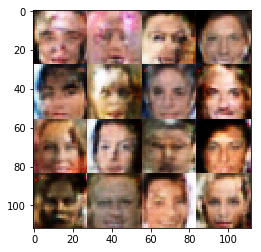

Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 0.5200... Generator Loss: 3.2591
Epoch 1/1... Discriminator Loss: 0.5307... Generator Loss: 3.1223
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 1.9492
Epoch 1/1... Discriminator Loss: 0.5797... Generator Loss: 2.1613
Epoch 1/1... Discriminator Loss: 0.5406... Generator Loss: 2.0836
Epoch 1/1... Discriminator Loss: 0.9232... Generator Loss: 1.0656
Epoch 1/1... Discriminator Loss: 1.5503... Generator Loss: 0.4231
Epoch 1/1... Discriminator Loss: 0.7469... Generator Loss: 1.2513
Epoch 1/1... Discriminator Loss: 0.5992... Generator Loss: 2.3383


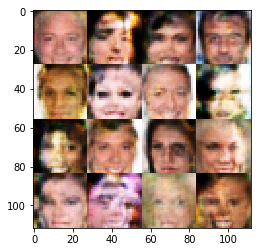

Epoch 1/1... Discriminator Loss: 0.8231... Generator Loss: 1.0028
Epoch 1/1... Discriminator Loss: 0.6492... Generator Loss: 1.7240
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 1.5552
Epoch 1/1... Discriminator Loss: 0.5628... Generator Loss: 2.2452
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.5233
Epoch 1/1... Discriminator Loss: 0.7748... Generator Loss: 1.1662
Epoch 1/1... Discriminator Loss: 0.5763... Generator Loss: 3.1681
Epoch 1/1... Discriminator Loss: 0.5595... Generator Loss: 1.7209
Epoch 1/1... Discriminator Loss: 0.4543... Generator Loss: 2.8495


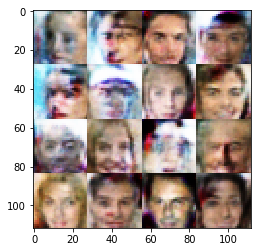

Epoch 1/1... Discriminator Loss: 0.8620... Generator Loss: 1.1829
Epoch 1/1... Discriminator Loss: 0.8412... Generator Loss: 1.1239
Epoch 1/1... Discriminator Loss: 0.9969... Generator Loss: 1.0619
Epoch 1/1... Discriminator Loss: 0.8006... Generator Loss: 1.1096
Epoch 1/1... Discriminator Loss: 0.5729... Generator Loss: 2.0386
Epoch 1/1... Discriminator Loss: 0.6317... Generator Loss: 2.7040
Epoch 1/1... Discriminator Loss: 0.7984... Generator Loss: 1.5901
Epoch 1/1... Discriminator Loss: 0.6751... Generator Loss: 1.3520
Epoch 1/1... Discriminator Loss: 0.9574... Generator Loss: 2.1369
Epoch 1/1... Discriminator Loss: 0.8727... Generator Loss: 2.1287


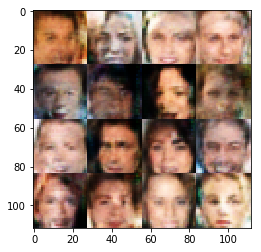

Epoch 1/1... Discriminator Loss: 0.7915... Generator Loss: 2.5567
Epoch 1/1... Discriminator Loss: 0.7186... Generator Loss: 1.4190
Epoch 1/1... Discriminator Loss: 0.7706... Generator Loss: 2.8041
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 2.1254
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 1.8065
Epoch 1/1... Discriminator Loss: 0.6174... Generator Loss: 1.5720
Epoch 1/1... Discriminator Loss: 0.8553... Generator Loss: 1.0202
Epoch 1/1... Discriminator Loss: 0.5939... Generator Loss: 1.6555
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 0.6798... Generator Loss: 1.4166


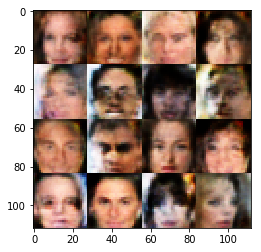

Epoch 1/1... Discriminator Loss: 0.7144... Generator Loss: 1.2303
Epoch 1/1... Discriminator Loss: 0.5474... Generator Loss: 2.5383
Epoch 1/1... Discriminator Loss: 0.7138... Generator Loss: 1.3641
Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 0.5023... Generator Loss: 2.1814


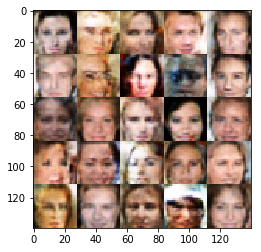

In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.125


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.